## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Load CIFAR

In [3]:
from tensorflow.keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [4]:
print(train_images.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


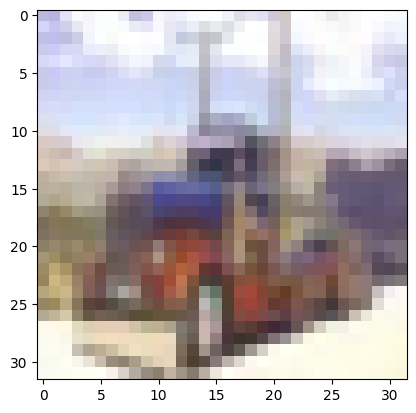

In [7]:
n = np.random.randint(1, 1000)
pixels = train_images[n,:,:,:]

plt.imshow(pixels)
plt.show()

In [9]:
print(train_labels[n])

[9]


In [36]:
print(train_images.min())
train_images.max()

0


255

In [37]:
train_images = train_images.astype('float32')
test_images= test_images.astype('float32')
# normalize to range 0-1
train_images= train_images / 255.0
test_images = test_images / 255.0

In [38]:
print(train_images.min())
train_images.max()

0.0


1.0

We need to make sure to one-hot encode the labels so there is no possibility of bias


In [39]:
print(np.unique(test_labels))
print(np.unique(train_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [40]:
encoder = OneHotEncoder(sparse=False)
train_enc = encoder.fit_transform(train_labels.reshape(-1, 1))
print(train_enc.shape)
print(train_enc[0:3,:])

(50000, 10)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [42]:
test_enc = encoder.fit_transform(test_labels.reshape(-1, 1))
print(test_enc.shape)
print(test_enc[0:3,:])

(10000, 10)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


Build CNN With 
- Convoltuional
- Pooling
- Flatten
- Dense

In [43]:
model_1CNN = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32,32,3)),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

In [44]:
model_1CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
history = model_1CNN.fit(train_images, train_enc, epochs=10, batch_size=32, validation_split=0.2)

Train model and save weights

In [46]:
model_1CNN.save('Model1_CNN.h5') 

Evaluate loss, accuracy, recall, precision, and confusion

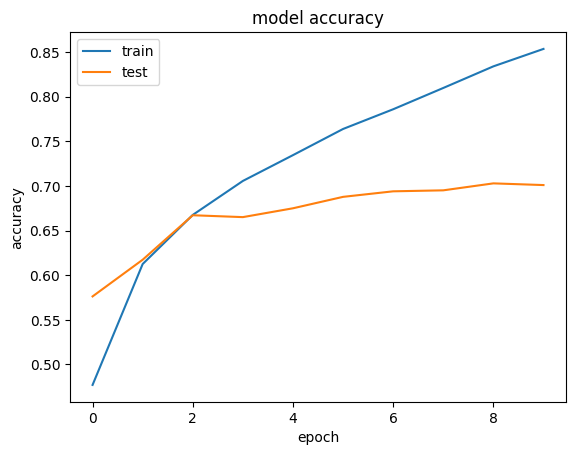

In [47]:
# Visualize Model Training History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


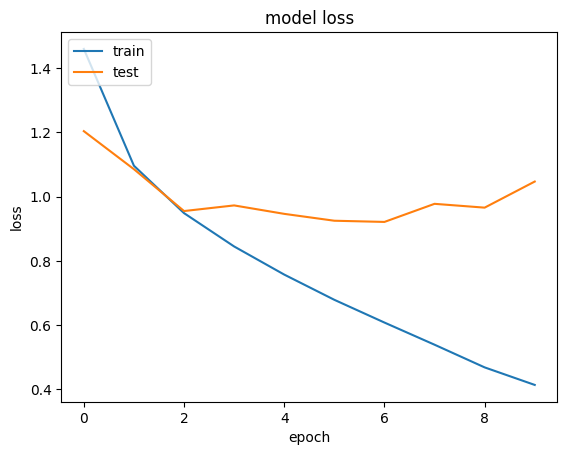

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
test_loss, test_accuracy = model_1CNN.evaluate(test_images, test_enc)

313/313 [==============================] - 2s 6ms/step - loss: 1.0701 - accuracy: 0.6926


In [50]:
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 1.070109248161316
Test Accuracy: 0.6926000118255615


In [51]:
predictions = model_1CNN.predict(test_images)
print(predictions.shape, test_enc.shape)

313/313 [==============================] - 2s 5ms/step
(10000, 10) (10000, 10)


In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_labels, np.argmax(predictions, axis=1))
print(cm)


[[762  21  53  17  21   4  10  10  63  39]
 [ 20 816   8  10   2   3   8   8  28  97]
 [ 82   8 635  69  78  34  37  28  15  14]
 [ 31   9  94 567  72 118  36  41  16  16]
 [ 24   6 106  84 628  27  31  74  10  10]
 [ 18   6  89 235  40 495  21  78   9   9]
 [  7   7  68  94  44  27 729  10  11   3]
 [ 28   2  40  47  74  39   9 733   3  25]
 [ 96  41  15  18   5   4   3   7 774  37]
 [ 35  90  14  19   4   7   4  10  30 787]]


Visualize Feature Maps

In [53]:
import matplotlib.pyplot as plt
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model_1CNN.layers]
activation_model = tf.keras.models.Model(inputs = model_1CNN.input, outputs = layer_outputs)
boat_list = [i for i in range(len(train_images)) if train_labels[i] == 8]
print(len(boat_list))
print(boat_list[0:10])
train_labels[boat_list[0:10]]

5000
[8, 62, 69, 92, 100, 106, 111, 135, 139, 155]


array([[8],
       [8],
       [8],
       [8],
       [8],
       [8],
       [8],
       [8],
       [8],
       [8]], dtype=uint8)

1/1 [==============================] - 0s 17ms/step


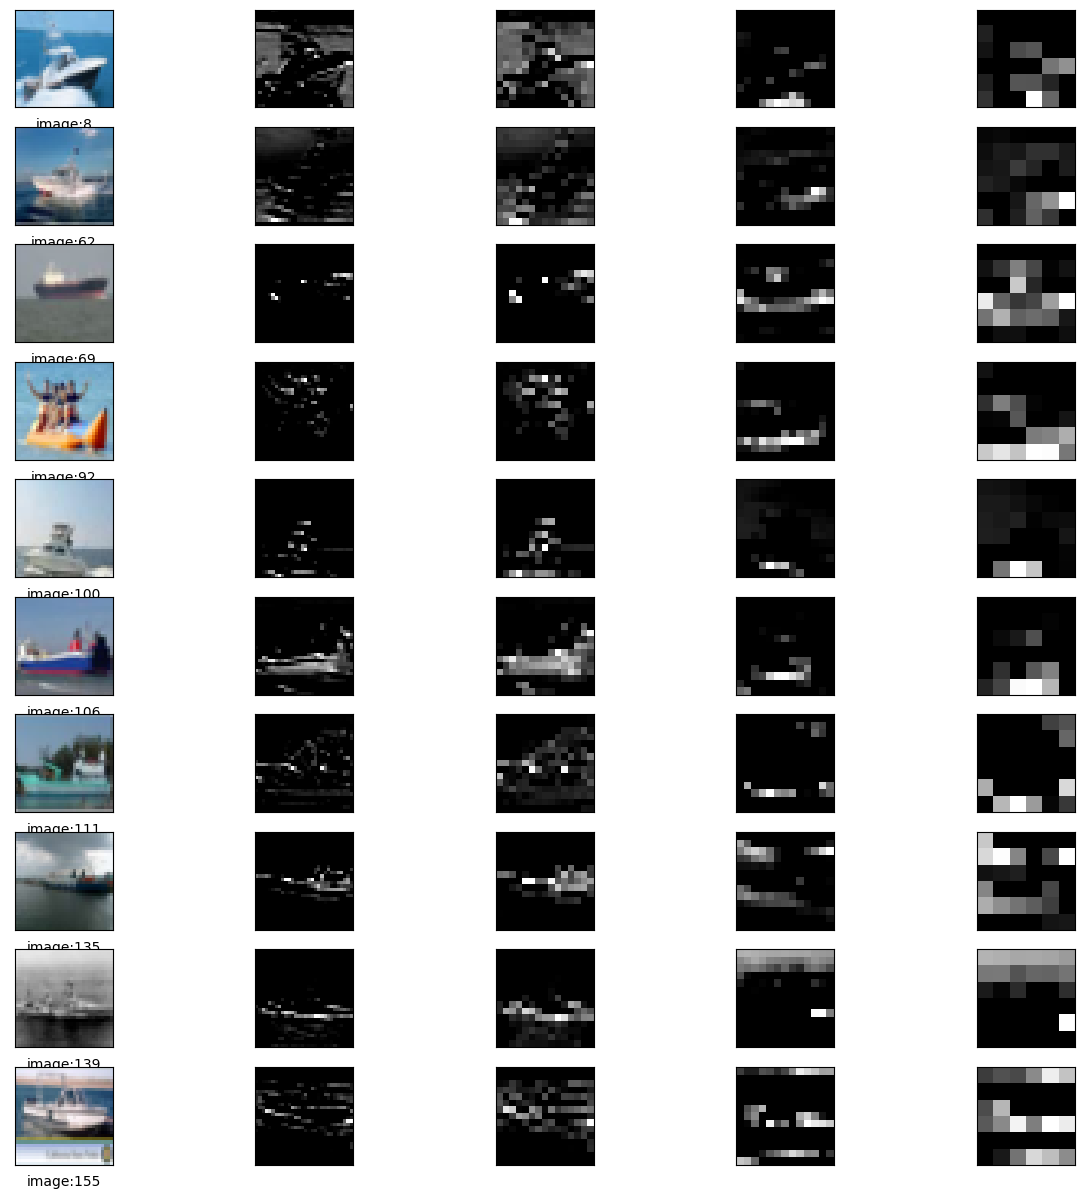

In [54]:
%matplotlib inline
import numpy as np
np.argmax(model_1CNN.predict(train_images[boat_list[0:10]]), axis=1)
f, ax = plt.subplots(10,5)
f.set_figheight(15)
f.set_figwidth(15)
plt.setp(ax, xticks=[], yticks=[])
for idx, k in enumerate(boat_list[0:10]):
    ax[idx,0].imshow(train_images[k], cmap='gray')
    ax[idx,0].set_xlabel('image:'+str(k))
    for lay_ind in range(0,4):
        f = activation_model.predict(train_images[k].reshape(1, 32,32,3))[lay_ind]
        ax[idx,lay_ind+1].imshow(f[0, : , :, 1], cmap='gray')

5000
[9, 17, 21, 26, 33, 36, 38, 39, 59, 74]
1/1 [==============================] - 0s 16ms/step


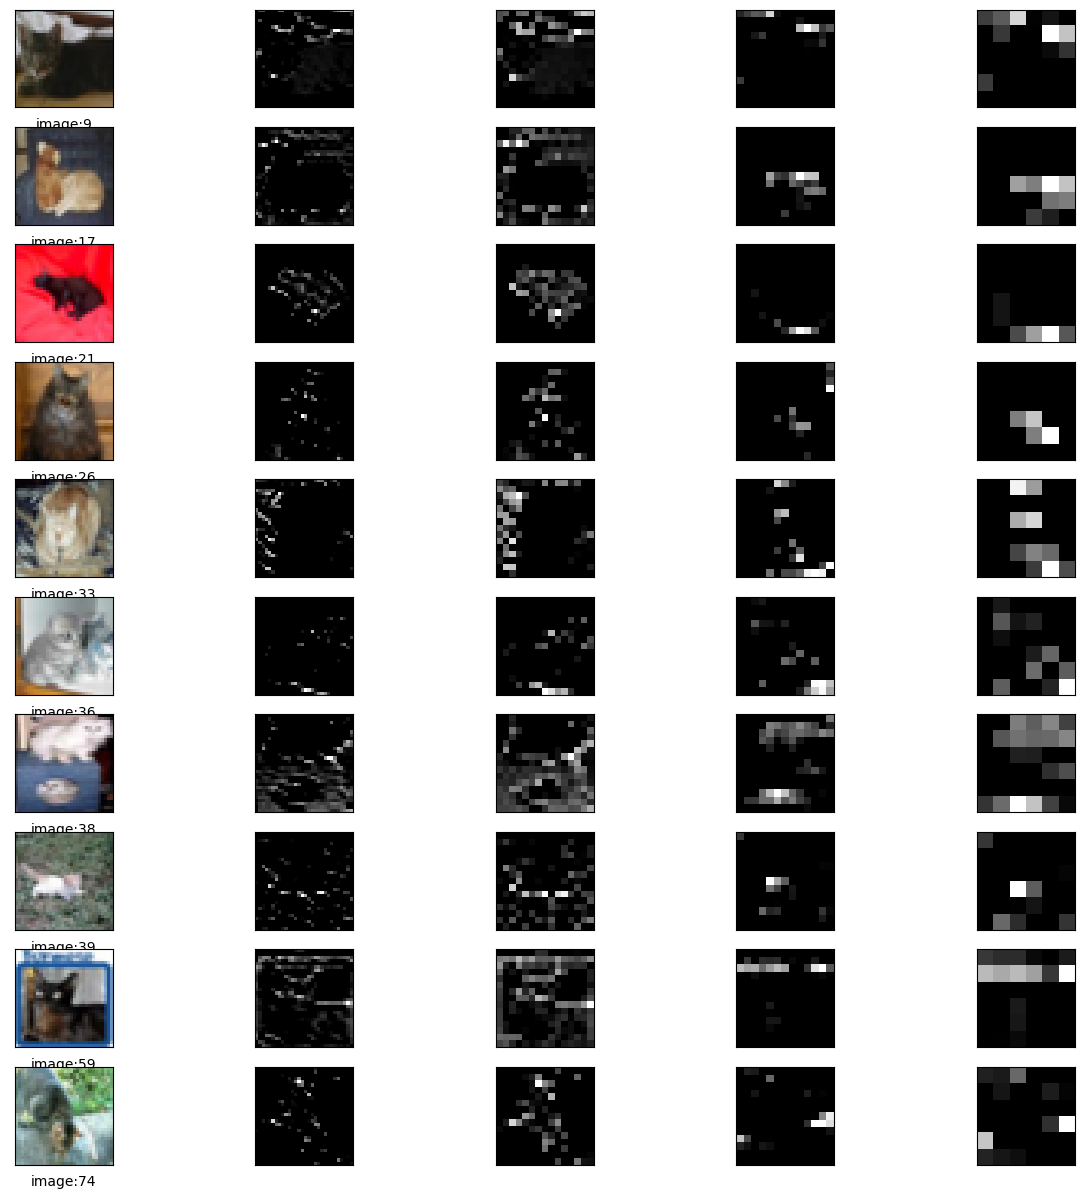

In [55]:
layer_outputs = [layer.output for layer in model_1CNN.layers]
activation_model = tf.keras.models.Model(inputs = model_1CNN.input, outputs = layer_outputs)
cat_list = [i for i in range(len(train_images)) if train_labels[i] == 3]
print(len(cat_list))
print(cat_list[0:10])
train_labels[cat_list[0:10]]

np.argmax(model_1CNN.predict(train_images[cat_list[0:10]]), axis=1)
f, ax = plt.subplots(10,5)
f.set_figheight(15)
f.set_figwidth(15)
plt.setp(ax, xticks=[], yticks=[])
for idx, k in enumerate(cat_list[0:10]):
    ax[idx,0].imshow(train_images[k], cmap='gray')
    ax[idx,0].set_xlabel('image:'+str(k))
    for lay_ind in range(0,4):
        f = activation_model.predict(train_images[k].reshape(1, 32,32,3))[lay_ind]
        ax[idx,lay_ind+1].imshow(f[0, : , :, 1], cmap='gray')

# Create Dense layer and train

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
# Define input layer. This specifies that model will receive input data of shape (784,)
input_tensor = Input(shape=(3072,))
# Build the rest of the model using the functional API
x = Dense(128, activation='relu')(input_tensor)
output_tensor = Dense(10, activation='softmax')(x)
# Instantiate the model
model = Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense_10 (Dense)            (None, 128)               393344    
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


In [56]:
Model2_Dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32,32,3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [57]:
Model2_Dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Model2_Dense.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               786688    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________


In [62]:
history2 = Model2_Dense.fit(train_images, train_enc, epochs=10,batch_size=32, validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4077 - accuracy: 0.4992 - val_loss: 1.4567 - val_accuracy: 0.4801
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3942 - accuracy: 0.5024 - val_loss: 1.4276 - val_accuracy: 0.4937
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3841 - accuracy: 0.5063 - val_loss: 1.4217 - val_accuracy: 0.4965
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3740 - accuracy: 0.5092 - val_loss: 1.4361 - val_accuracy: 0.4847
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3650 - accuracy: 0.5121 - val_loss: 1.4837 - val_accuracy: 0.4767
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3563 - accuracy: 0.5145 - val_loss: 1.4489 - val_accuracy: 0.4849
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3431 - accuracy: 0.5188 - val_loss: 1.4402 - val_accuracy:

Save model and evaluate

In [63]:
model_1CNN.save('Model2_Dense.h5') 

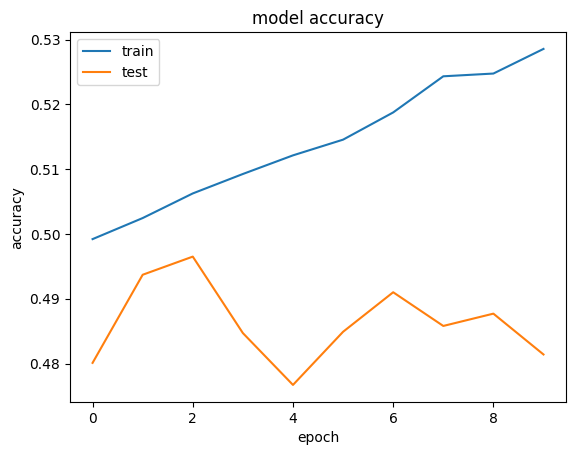

In [64]:
# Visualize Model Training History
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

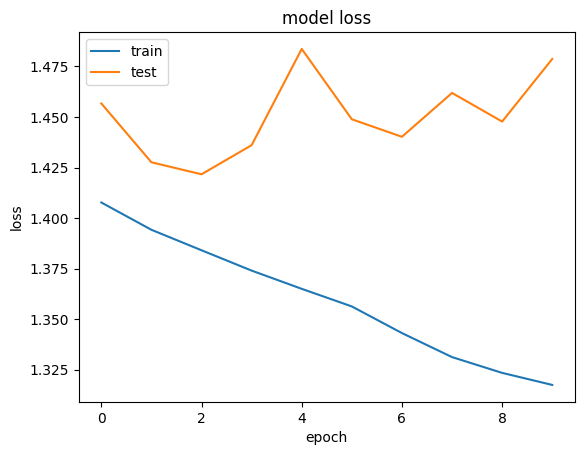

In [65]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
test_loss, test_accuracy = Model2_Dense.evaluate(test_images, test_enc)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


313/313 [==============================] - 0s 1ms/step - loss: 1.4958 - accuracy: 0.4735
Test Loss: 1.495790958404541
Test Accuracy: 0.47350001335144043


In [67]:
predictions = Model2_Dense.predict(test_images)
print(predictions.shape, test_enc.shape)

cm = confusion_matrix(test_labels, np.argmax(predictions, axis=1))
print(cm)


313/313 [==============================] - 0s 1ms/step
(10000, 10) (10000, 10)
[[510  23  44  23  18  15  32  43 199  93]
 [ 41 459  15  27   5  18  29  30 103 273]
 [ 79  24 267 125 101  63 179  80  43  39]
 [ 38  16  70 344  33 144 181  52  49  73]
 [ 51   4  98  89 311  38 236  91  45  37]
 [ 27  14  72 241  31 332 124  59  56  44]
 [ 13  10  44 104  58  39 655  17  20  40]
 [ 35  15  41  89  51  71  75 506  24  93]
 [ 85  40   6  33  12  11   9  17 697  90]
 [ 36  93   8  35   3  21  40  32  78 654]]


# CNN vs Dense Results

Accuracy during Training:
    - CNN
    - Dense
Accuracy during Testing:
    - CNN
    - Dense
Advantages 
    - CNN - accuracy, robustness
    - Dense - training time, simplicity
Limitations
    - CNN - long training time, more nuance architecture
    - Dense

Adjust CNN by adding another convolutional pooling

In [70]:
model_2CNN = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(32,32,3)),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])


In [71]:
model_2CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        73792     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 2, 2, 64)        

In [73]:
history3 = model_2CNN.fit(train_images, train_enc, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5905 - accuracy: 0.4171 - val_loss: 1.3241 - val_accuracy: 0.5305
Epoch 2/10
1250/1250 [==============================] - 65s 52ms/step - loss: 1.2339 - accuracy: 0.5635 - val_loss: 1.2427 - val_accuracy: 0.5716
Epoch 3/10
1250/1250 [==============================] - 69s 56ms/step - loss: 1.0858 - accuracy: 0.6174 - val_loss: 1.0554 - val_accuracy: 0.6328
Epoch 4/10
1250/1250 [==============================] - 71s 56ms/step - loss: 0.9915 - accuracy: 0.6496 - val_loss: 0.9986 - val_accuracy: 0.6543
Epoch 5/10
1250/1250 [==============================] - 72s 58ms/step - loss: 0.9143 - accuracy: 0.6796 - val_loss: 0.9396 - val_accuracy: 0.6743
Epoch 6/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.8501 - accuracy: 0.7006 - val_loss: 0.9447 - val_accuracy: 0.6701
Epoch 7/10
1250/1250 [==============================] - 66s 53ms/step - loss: 0.7982 - accuracy: 0.7197 - val_loss: 0.9497 -

In [74]:
model_1CNN.save('model_2CNN.h5') 

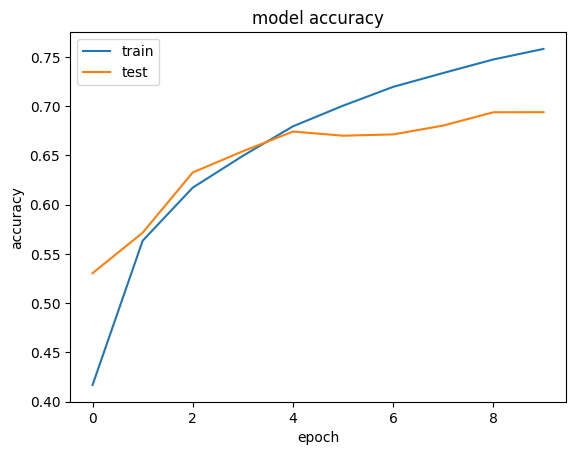

In [75]:
# Visualize Model Training History
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

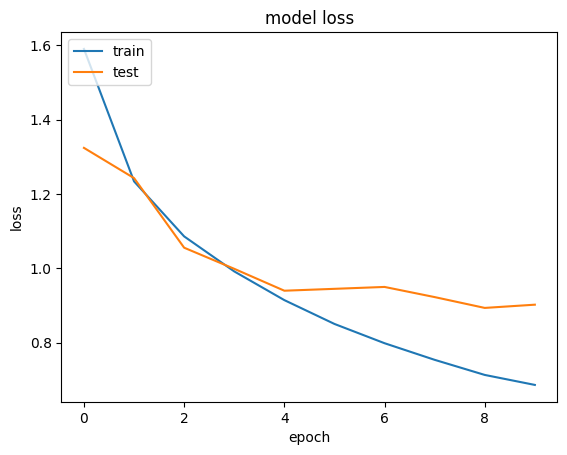

In [76]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
test_loss, test_accuracy = model_2CNN.evaluate(test_images, test_enc)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


313/313 [==============================] - 3s 11ms/step - loss: 0.9055 - accuracy: 0.6955
Test Loss: 0.9054577946662903
Test Accuracy: 0.6955000162124634


In [78]:
predictions = model_2CNN.predict(test_images)
print(predictions.shape, test_enc.shape)

cm = confusion_matrix(test_labels, np.argmax(predictions, axis=1))
print(cm)


313/313 [==============================] - 3s 10ms/step
(10000, 10) (10000, 10)
[[726  18  28  11  21  10  10  23  88  65]
 [ 20 771   5   4   3   7  10   1  27 152]
 [ 81   9 494  51 102  91  77  53  24  18]
 [ 18   7  49 391  71 247  69  80  25  43]
 [ 16   5  57  41 614  59  51 123  15  19]
 [  9   2  39  95  43 680  22  78   9  23]
 [  5   3  34  39  42  39 791  14  11  22]
 [ 10   3  18  25  43  59   4 809   7  22]
 [ 63  29   7   6   8   6   7  10 821  43]
 [ 19  53   5   5   5   7   7  14  27 858]]


In [79]:
import matplotlib.pyplot as plt
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model_2CNN.layers]
activation_model = tf.keras.models.Model(inputs = model_2CNN.input, outputs = layer_outputs)
boat_list = [i for i in range(len(train_images)) if train_labels[i] == 8]
print(len(boat_list))
print(boat_list[0:10])
train_labels[boat_list[0:10]]

5000
[8, 62, 69, 92, 100, 106, 111, 135, 139, 155]


array([[8],
       [8],
       [8],
       [8],
       [8],
       [8],
       [8],
       [8],
       [8],
       [8]], dtype=uint8)

1/1 [==============================] - 0s 18ms/step


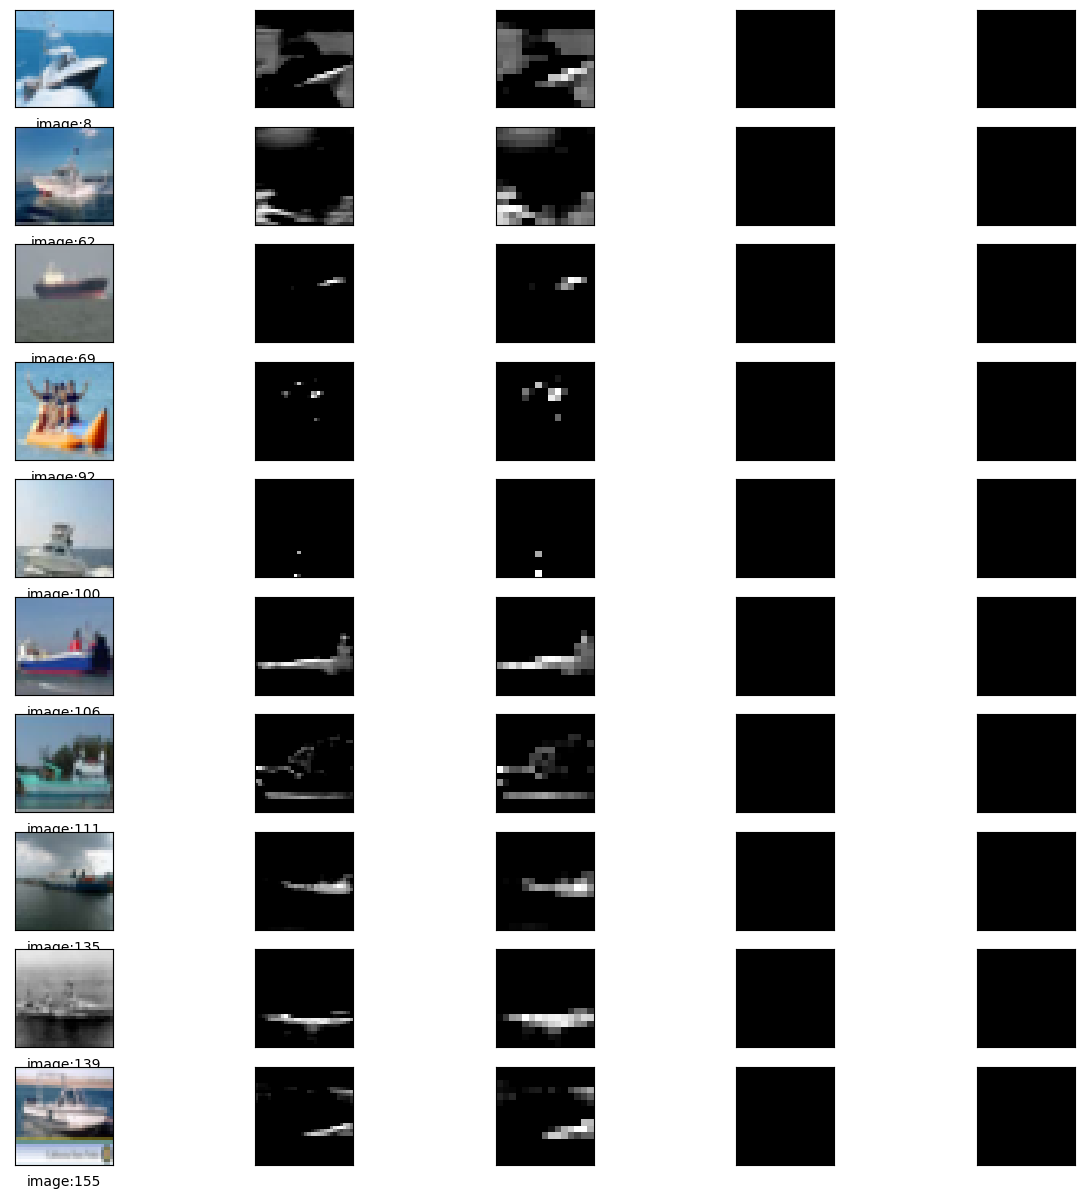

In [80]:
%matplotlib inline
import numpy as np
np.argmax(model_2CNN.predict(train_images[boat_list[0:10]]), axis=1)
f, ax = plt.subplots(10,5)
f.set_figheight(15)
f.set_figwidth(15)
plt.setp(ax, xticks=[], yticks=[])
for idx, k in enumerate(boat_list[0:10]):
    ax[idx,0].imshow(train_images[k], cmap='gray')
    ax[idx,0].set_xlabel('image:'+str(k))
    for lay_ind in range(0,4):
        f = activation_model.predict(train_images[k].reshape(1, 32,32,3))[lay_ind]
        ax[idx,lay_ind+1].imshow(f[0, : , :, 1], cmap='gray')

5000
[9, 17, 21, 26, 33, 36, 38, 39, 59, 74]
1/1 [==============================] - 0s 18ms/step


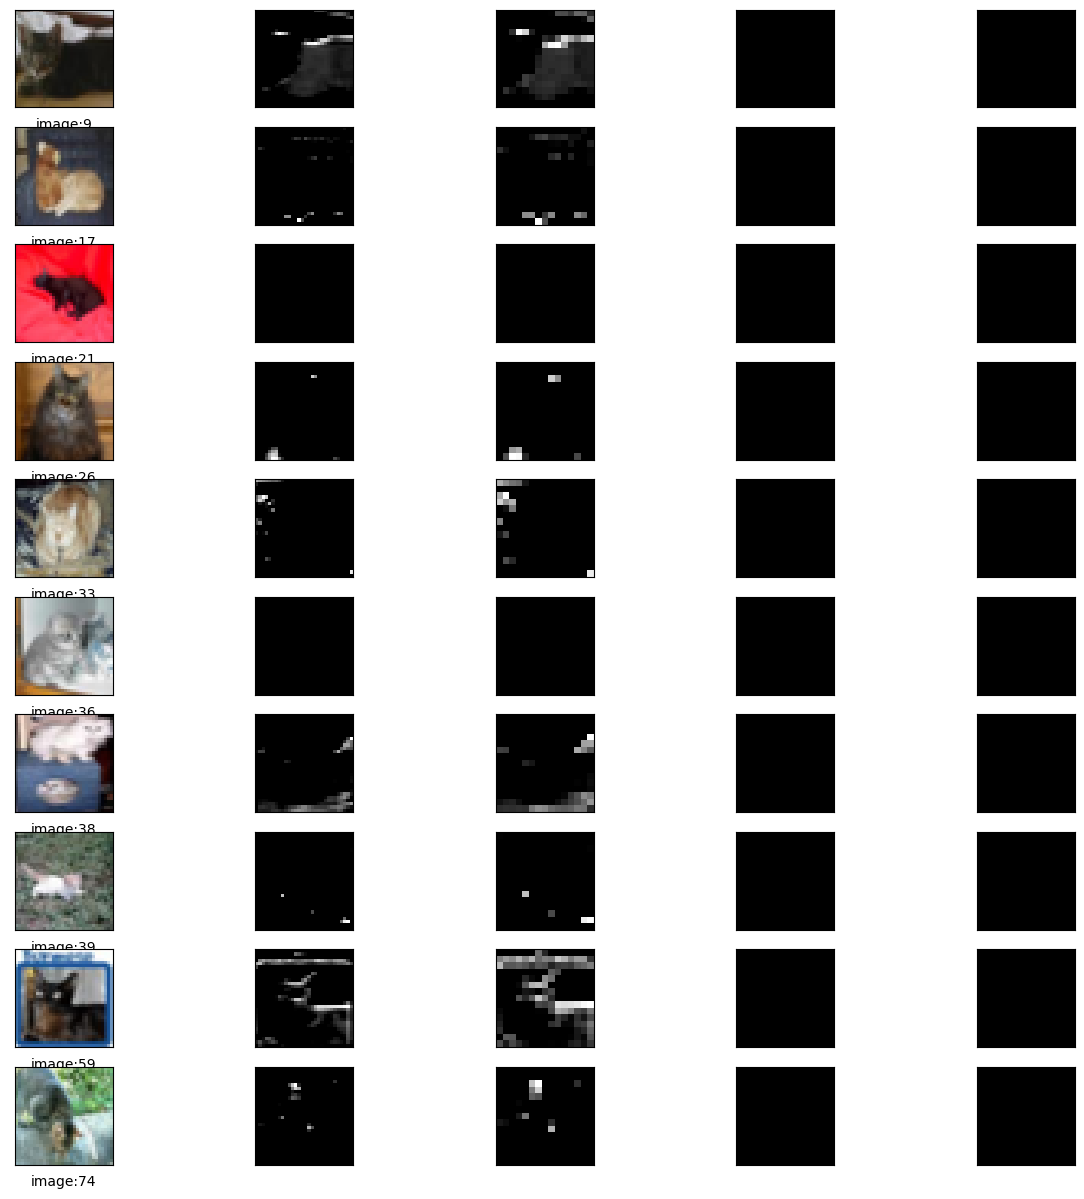

In [81]:
layer_outputs = [layer.output for layer in model_2CNN.layers]
activation_model = tf.keras.models.Model(inputs = model_2CNN.input, outputs = layer_outputs)
cat_list = [i for i in range(len(train_images)) if train_labels[i] == 3]
print(len(cat_list))
print(cat_list[0:10])
train_labels[cat_list[0:10]]

np.argmax(model_1CNN.predict(train_images[cat_list[0:10]]), axis=1)
f, ax = plt.subplots(10,5)
f.set_figheight(15)
f.set_figwidth(15)
plt.setp(ax, xticks=[], yticks=[])
for idx, k in enumerate(cat_list[0:10]):
    ax[idx,0].imshow(train_images[k], cmap='gray')
    ax[idx,0].set_xlabel('image:'+str(k))
    for lay_ind in range(0,4):
        f = activation_model.predict(train_images[k].reshape(1, 32,32,3))[lay_ind]
        ax[idx,lay_ind+1].imshow(f[0, : , :, 1], cmap='gray')

Evaluate Original CNN, Adjusted CNN, and Dense

In [ ]:
Model 1
Test Loss: 1.070109248161316
Test Accuracy: 0.6926000118255615

In [ ]:
RERUN Dense


In [ ]:
Model 2
Test Loss: 0.9054577946662903
Test Accuracy: 0.6955000162124634